# Chelan 2: Assessing turbidity signal within RGB bands

Jason MacDonald  
UW Geospatial Data Analysis  
CEWA567 - Winter 2023  
credit to: David Shean, for instruction, guidance, and sample code  
credit to: Eric Gagliano, for additional guidance and sample code  

[Chelan_0 Query Data](./chelan_0_query-data_2021.ipynb) << RUN THIS FIRST  
[Chelan_1 Site Exploration](./chelan_1_site-exploration.ipynb)  
[Chelan_2 RGB Analysis](./chelan_2_rgb-analysis.ipynb)   
[Chelan_3 Timeseries Visualization](./chelan_3_timeseries-visualization.ipynb)  
[Chelan_4 Affected Area Analysis](./chelan_4_affected-area-analysis.ipynb)

## Access images

In [1]:
import os
import urllib
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import geopandas as gpd
from datetime import datetime

In [2]:
import rasterio as rio
import rasterio.windows
import rasterio.plot
from rasterio import plot, mask
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [3]:
#Useful package to add dynamic scalebar to matplotlib images
from matplotlib_scalebar.scalebar import ScaleBar
#for titles
from textwrap import wrap
#for legend
import matplotlib.patches as mpatches 

In [4]:
!pip install earthaccess

In [5]:
import earthaccess

auth = earthaccess.login(strategy="netrc")
if not auth:
    auth = earthaccess.login(strategy="interactive", persist=True)
# run single line below first time
#auth = earthaccess.login(strategy="interactive", persist=True)

You're now authenticated with NASA Earthdata Login
Using token with expiration date: 05/10/2023
Using .netrc file for EDL


## Raster window extraction
* Instead of array indexing, we can use the built-in `rasterio.windows.Window` functionality
    * This is really valuable when you only want to load a small portion of a large dataset that is too big to fit into available RAM
        * With array indexing, we must load the entire array into memory and then extract the desired window
        * With the rasterio window, we never have to load the full array
    * https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html
    * Syntax is `rasterio.windows.Window(col_offset, row_offset, width, height)`
* Let's define 1024x1024 px windows around Mt. Rainer and Seattle

In [6]:
# Set our rasterio window about Lake Chelan
# choose this now, so we can include it in our output folder
# used iteration find area of interest

#Lake Chelan
#window = rasterio.windows.Window(1750, 1000, 2048, 2048)
#window = rasterio.windows.Window(2400, 1500, 512, 1024)
#window = rasterio.windows.Window(2250, 1500, 512, 512)

#same window shape as chelan geom
window_id = 'lucerne_basin'
window = rasterio.windows.Window(2400, 1500, 1255, 1755)

In [7]:
#May want to use interactive plotting for zoom/pan and live coordinate display
#%matplotlib widget
#%matplotlib inline

In [8]:
pwd

'/home/jovyan/project/chelanigans'

In [9]:
#Set up directory for output
notebook = 'chelan_2_rgb-analysis'
path = ('/home/jovyan/project/chelanigans/output/%s/%s' %(notebook, window_id))
isExist = os.path.exists(path)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(path)

In [10]:
#access gdf output from query notebook
path = './output/chelan_0_query-data_2021/gf_lesscloud_20_sentinel.geoJSON' #relative path
#path = '/home/jovyan/project/chelanigans/output/chelan_0_query-data_2021/gf_lesscloud_20_sentinel.geoJSON' #absolute path
gf_lesscloud_20_sentinel = gpd.read_file(path)
gf_lesscloud_20_sentinel_df = pd.DataFrame(gf_lesscloud_20_sentinel, columns=('eo:cloud_cover', 'stac_id', 'time', 'platform'))
gf_lesscloud_20_sentinel_df

,eo:cloud_cover,stac_id,time,platform
0,5,HLS.S30.T10UFU.2021062T190301.v2.0,2021-03-03 19:11:08.571000+00:00,S
1,16,HLS.S30.T10UFU.2021092T185921.v2.0,2021-04-02 19:11:05.535000+00:00,S
2,0,HLS.S30.T10UFU.2021107T185909.v2.0,2021-04-17 19:11:04.007000+00:00,S
3,9,HLS.S30.T10UFU.2021142T185921.v2.0,2021-05-22 19:11:09.221000+00:00,S
4,0,HLS.S30.T10UFU.2021152T185921.v2.0,2021-06-01 19:11:09.530000+00:00,S
5,1,HLS.S30.T10UFU.2021172T185921.v2.0,2021-06-21 19:11:09.531000+00:00,S
6,0,HLS.S30.T10UFU.2021177T185919.v2.0,2021-06-26 19:11:09.416000+00:00,S
7,4,HLS.S30.T10UFU.2021187T185919.v2.0,2021-07-06 19:11:10.358000+00:00,S
8,1,HLS.S30.T10UFU.2021192T185921.v2.0,2021-07-11 19:11:11.712000+00:00,S
9,10,HLS.S30.T10UFU.2021207T185919.v2.0,2021-07-26 19:11:10.637000+00:00,S


## PNW 2021 heatwave dates: June 26 - July 2

In [11]:
#for ease of access to stac_id and date

gdf = gf_lesscloud_20_sentinel   
#for cloud, stac_id, time in gdf:
img_list = [stac_id for stac_id in gdf['stac_id']]
date_list = [time.date().strftime('%Y-%m-%d') for time in gdf['time']]
print(date_list, img_list)

['2021-03-03', '2021-04-02', '2021-04-17', '2021-05-22', '2021-06-01', '2021-06-21', '2021-06-26', '2021-07-06', '2021-07-11', '2021-07-26', '2021-09-24'] ['HLS.S30.T10UFU.2021062T190301.v2.0', 'HLS.S30.T10UFU.2021092T185921.v2.0', 'HLS.S30.T10UFU.2021107T185909.v2.0', 'HLS.S30.T10UFU.2021142T185921.v2.0', 'HLS.S30.T10UFU.2021152T185921.v2.0', 'HLS.S30.T10UFU.2021172T185921.v2.0', 'HLS.S30.T10UFU.2021177T185919.v2.0', 'HLS.S30.T10UFU.2021187T185919.v2.0', 'HLS.S30.T10UFU.2021192T185921.v2.0', 'HLS.S30.T10UFU.2021207T185919.v2.0', 'HLS.S30.T10UFU.2021267T190029.v2.0']


In [12]:
#Set path to local directory with downloaded images

imgdir = '/home/jovyan/project/chelanigans/data'

In [13]:
#Define image to use (can set this to switch to pre/post heatwave image
img = img_list[-1]
date = date_list[-1]

In [14]:
#Scale and offset values for L2 Landsat products

# are these same/similar for Sentinel-2?
# check metadata for values

#Surface Reflectance 0.0000275 + -0.2
sr_scale = 0.0000275
sr_offset = -0.2
#Surface Temperature 0.00341802 + 149.0
st_scale = 0.00341802
st_offset = 149.0

In [15]:
#Specify filenames for different bands

r_fn = os.path.join(imgdir, img+'.B04.tif') #Red
g_fn = os.path.join(imgdir, img+'.B03.tif') #Green
b_fn = os.path.join(imgdir, img+'.B02.tif') #Blue
nir_fn = os.path.join(imgdir, img+'.B08.tif') #Near-Infrared (NIR08)
swir_fn = os.path.join(imgdir, img+'.B11.tif') #Shortwave-Infrared (SWIR16)

In [16]:
#Sentinel-2
base_url = 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020'
#full_url = 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10UFU.2021362T190811.v2.0/HLS.S30.T10UFU.2021362T190811.v2.0.B02.tif'

#landsat
#base_url = 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020'  
#full_url = 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T10UFU.2022001T185530.v2.0/HLS.L30.T10UFU.2022001T185530.v2.0.B02.tif'

band_list = ('02', '03', '04', '05', '06', '07', '08', '09', '10', '11') 

#Loop through all selected images and bands
for img in img_list:
    for b in band_list:
    #Generate the appropriate URL for the images we identified
        image_url =  '{0}/{1}/{1}.B{2}.tif'.format(base_url, img, b)    
        print(image_url)
    #Local filename
        out_fn = os.path.join(imgdir, os.path.split(image_url)[-1])
    #Check to see if file already exists
    if not os.path.exists(out_fn):
        print("Saving:", out_fn)
        
        #Download the file
        #figure out authorization here
        urllib.request.urlretrieve(image_url, out_fn)

https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10UFU.2021062T190301.v2.0/HLS.S30.T10UFU.2021062T190301.v2.0.B02.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10UFU.2021062T190301.v2.0/HLS.S30.T10UFU.2021062T190301.v2.0.B03.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10UFU.2021062T190301.v2.0/HLS.S30.T10UFU.2021062T190301.v2.0.B04.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10UFU.2021062T190301.v2.0/HLS.S30.T10UFU.2021062T190301.v2.0.B05.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10UFU.2021062T190301.v2.0/HLS.S30.T10UFU.2021062T190301.v2.0.B06.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10UFU.2021062T190301.v2.0/HLS.S30.T10UFU.2021062T190301.v2.0.B07.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10UFU.202106

In [17]:
#Sanity check
#Leave this Dataset open for use later in lab (e.g., extracting resolution)
r_src = rio.open(r_fn)
print("MS", r_src.profile)

MS {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 3660, 'height': 3660, 'count': 1, 'crs': CRS.from_wkt('PROJCS["UTM Zone 10, Northern Hemisphere",GEOGCS["Unknown datum based upon the WGS 84 ellipsoid",DATUM["Not specified (based on WGS 84 spheroid)",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, 600000.0,
       0.0, -30.0, 5400000.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


In [18]:
#Define window bounds
window_bounds = rasterio.windows.bounds(window, r_src.transform)
print("Window bounds: ", window_bounds)
#Define window extent
window_extent = [window_bounds[0], window_bounds[2], window_bounds[1], window_bounds[3]]
print("Window extent: ", window_extent)

Window bounds:  (672000.0, 5302350.0, 709650.0, 5355000.0)
Window extent:  [672000.0, 709650.0, 5302350.0, 5355000.0]


### Function to read only this subwindow into an array

In [19]:
def rio2ma(fn, b=1, window=None, scale=True):
    with rio.open(fn) as src:
        #Read in the window to masked array
        a = src.read(b, window=window, masked=True)
        #If Level 2 surface reflectance and surface temperature, scale values appropriately
        if scale:
            if 'SR' in fn:
                #Output in unitless surface reflectance from 0-1
                a = a * sr_scale + sr_offset
            elif 'ST' in fn:
                #Output in degrees Celsius
                a = a * st_scale + st_offset - 273.15
            a = a.astype('float32')
        return a

### Function to normalize (AKA contrast stretch) input image array values
* The input image pixel values are `UInt16` (unsigned, 16-bit integer, spanning the range 0-65535)
* We want to rescale to `float` values over the range (0.0-1.0)

In [20]:
def normie(data, low_perc, up_perc):
    perc = np.percentile(data.compressed(), (low_perc, up_perc)) #default (2, 98)
    normd = (data - perc[0])/(perc[1] - perc[0])
    clipd = np.clip(normd, 0, 1)
    return clipd

In [21]:
# load window from red, green, blue tif files
r = rio2ma(r_fn, b=1, window=window, scale=True)
g = rio2ma(g_fn, b=1, window=window, scale=True)
b = rio2ma(b_fn, b=1, window=window, scale=True)
nir = rio2ma(nir_fn, b=1, window=window, scale=True)
swir = rio2ma(swir_fn, window=window, scale=True)

r_norm = normie(r, 2, 98)
g_norm = normie(g, 2, 98)
b_norm = normie(b, 2, 98)
nir_norm = normie(nir, 2, 98)
swir_norm = normie(swir, 2, 98)

#r_norm = normie(r, 0.1, 25)
#g_norm = normie(g, 0.1, 25)
#b_norm = normie(b, 0.1, 25)

fin = np.dstack((r_norm,g_norm,b_norm))
fin.shape

(1755, 1255, 3)

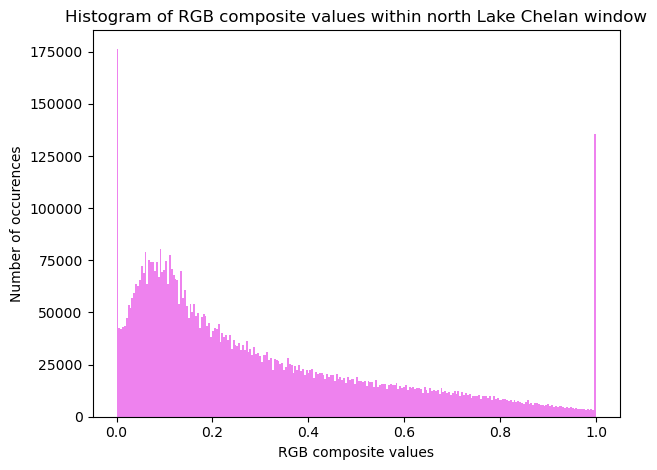

In [22]:
fig, ax = plt.subplots()

#w = 0.1

ax.hist(fin.compressed().ravel(), bins=256, color='violet', log=False)

#ax.axvline(w, ls='--', c='g', label=w)
#ax.legend()
ax.set_ylabel('Number of occurences')
ax.set_xlabel('RGB composite values')
ax.set_title('Histogram of RGB composite values within north Lake Chelan window')
plt.tight_layout();

## Need to:
* isolate Lake Chelan by geometry object
* evaluate RGB bands individually to access turbidity signal

In [23]:
#!pip install opencv-python

In [24]:
#not working now, may come back to this later

#for detecting polygons from image (or skip first few lines and enter ndwi_chelan)
#https://www.tutorialspoint.com/how-to-detect-polygons-in-image-using-opencv-python

# import required libraries
#import cv2

# read the input image
#img = cv2.imread('polygons.png')

# convert the image to grayscale
#gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# apply thresholding to convert the grayscale image to a binary image
#ret,thresh = cv2.threshold(gray,50,255,0)
#img = ndwi
#thresh = ndwi_mask

# find the contours
#contours,hierarchy = cv2.findContours(thresh, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
#print("Number of contours detected:",len(contours))
#for cnt in contours:
#   approx = cv2.approxPolyDP(cnt, 0.01*cv2.arcLength(cnt, True), True)
#   (x,y)=cnt[0,0]

#   if len(approx) >= 5:
#      img = cv2.drawContours(img, [approx], -1, (0,255,255), 3)
#      cv2.putText(img, 'Polygon', (x, y),
#cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)
#cv2.imshow("Polygon", img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [25]:
#chelan_json_url = '#https://geo.wa.gov/datasets/WSDOT::wsdot-major-lakes-1500k/explore?filters=eyJOQU1FIjpbIkxha2UgQ2hlbGFuIl19&location=48.085597%2C-120.767080%2C9.89'
wa_lakes_gjson_url = '/home/jovyan/project/chelanigans/data/WSDOT_-_Major_Lakes_(1%3A500K).geojson'
wa_lakes_gjson_gdf = gpd.read_file(wa_lakes_gjson_url) #just pointing to downloaded file for now
#Reproject to match raster
wa_lakes_gjson_gdf_proj = wa_lakes_gjson_gdf.to_crs(r_src.crs)
#Isolate WA state
chelan_gjson_iso = wa_lakes_gjson_gdf_proj.loc[wa_lakes_gjson_gdf_proj['NAME'] == 'Lake Chelan']
#Extract geometry to use for clipping
chelan_geom = chelan_gjson_iso.iloc[0].geometry

In [26]:
#Pass this in to the `rio.mask.mask` call (see demo)
rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
#must pass chelan_geom polygon as list because rio.mask.mask expects multipolygon
chelan_mask, chelan_mask_transform = rio.mask.mask(r_src, [chelan_geom,], **rio_mask_kwargs)

In [27]:
#Get clipped extent in UTM coordinates
chelan_mask_extent = rio.plot.plotting_extent(chelan_mask, chelan_mask_transform)
chelan_mask_extent

(672150.0, 709800.0, 5302170.0, 5354820.0)

In [28]:
#mask rgb bands where chelan mask (based on geom) is true (outside geometry of lake chelan)
r_masked = ma.masked_where(chelan_mask==True,r)
g_masked = ma.masked_where(chelan_mask==True,g)
b_masked = ma.masked_where(chelan_mask==True,b)
nir_masked = ma.masked_where(chelan_mask==True,nir)

In [29]:
#%matplotlib widget

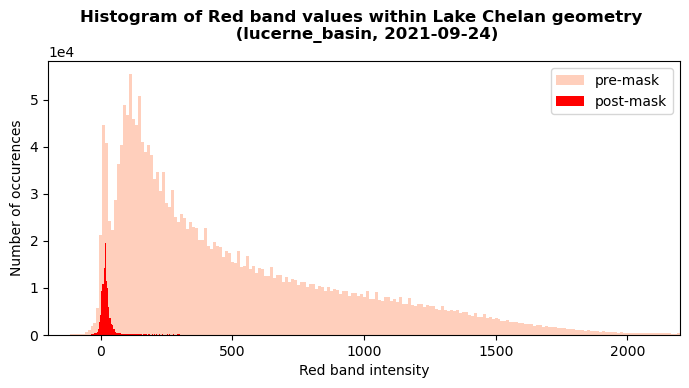

In [30]:
fig, ax = plt.subplots(figsize=(7,4))

ax.hist(r.compressed().ravel(), bins=512, color='lightsalmon', alpha=.5, log=False, label='pre-mask')
ax.hist(r_masked.compressed().ravel(), bins=512, color='red', log=False, label='post-mask')

ax.ticklabel_format(axis='y', scilimits=(1,3))
ax.legend()
ax.set_xlim(-200, 2200)
ax.set_ylabel('Number of occurences', fontsize=10)
ax.set_xlabel('Red band intensity', fontsize=10)
ax.set_title('Histogram of Red band values within Lake Chelan geometry \n (%s, %s)' %(window_id, date), fontsize=12, fontweight='bold', y=1.05)
plt.tight_layout()

#save image output
strFile = ('/home/jovyan/project/chelanigans/output/%s/%s/red-signal_%s.png' %(notebook, window_id, date))
if os.path.isfile(strFile):
#os.remove(strFile)
    os.system("rm "+strFile)
plt.savefig(strFile);

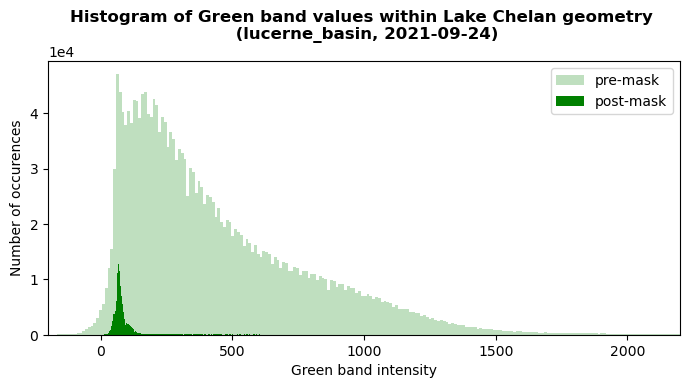

In [31]:
fig, ax = plt.subplots(figsize=(7,4))

ax.hist(g.compressed().ravel(), bins=512, color='green', alpha=.25, log=False, label='pre-mask')
ax.hist(g_masked.compressed().ravel(), bins=512, color='green', log=False, label='post-mask')

ax.ticklabel_format(axis='y', scilimits=(1,3))
ax.legend()
ax.set_xlim(-200, 2200)
ax.set_ylabel('Number of occurences', fontsize=10)
ax.set_xlabel('Green band intensity', fontsize=10)
ax.set_title('Histogram of Green band values within Lake Chelan geometry \n (%s, %s)' %(window_id, date), fontsize=12, fontweight='bold', y=1.05)
plt.tight_layout()

#save image output
strFile = ('/home/jovyan/project/chelanigans/output/%s/%s/green-signal_%s.png' %(notebook, window_id, date))
if os.path.isfile(strFile):
#os.remove(strFile)
    os.system("rm "+strFile)
plt.savefig(strFile);

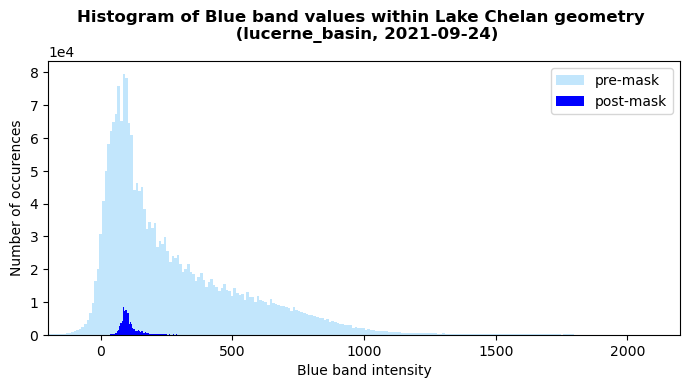

In [32]:
fig, ax = plt.subplots(figsize=(7,4))

ax.hist(b.compressed().ravel(), bins=512, color='lightskyblue', alpha=.5, log=False, label='pre-mask')
ax.hist(b_masked.compressed().ravel(), bins=512, color='blue', log=False, label='post-mask')

ax.ticklabel_format(axis='y', scilimits=(1,3))
ax.legend()
ax.set_xlim(-200, 2200)
ax.set_ylabel('Number of occurences', fontsize=10)
ax.set_xlabel('Blue band intensity', fontsize=10)
ax.set_title('Histogram of Blue band values within Lake Chelan geometry \n (%s, %s)' %(window_id, date), fontsize=12, fontweight='bold', y=1.05)
plt.tight_layout()

#save image output
strFile = ('/home/jovyan/project/chelanigans/output/%s/%s/blue-signal_%s.png' %(notebook, window_id, date))
if os.path.isfile(strFile):
#os.remove(strFile)
    os.system("rm "+strFile)
plt.savefig(strFile);

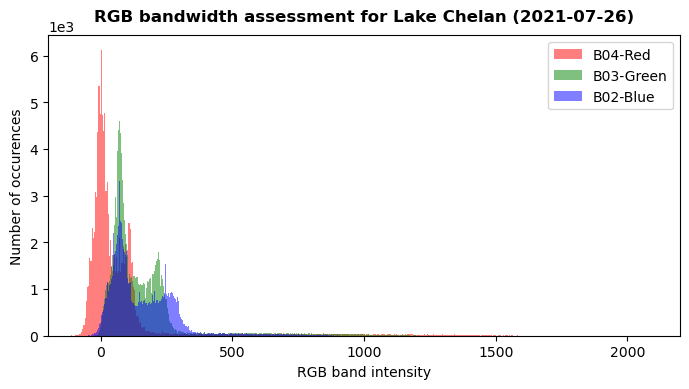

In [40]:
fig, ax = plt.subplots(figsize=(7,4))

ax.hist(r_masked.compressed().ravel(), bins=512, alpha=0.5, color='red', log=False, label='B04-Red')
#ax.axvline(red_threshold, ls='--', c='k', label=red_threshold)

ax.hist(g_masked.compressed().ravel(), bins=512, alpha=0.5, color='green', log=False, label='B03-Green')
#ax.axvline(red_threshold, ls='--', c='k', label=red_threshold)

ax.hist(b_masked.compressed().ravel(), bins=512, alpha=0.5, color='blue', log=False, label='B02-Blue')
#ax.axvline(red_threshold, ls='--', c='k', label=red_threshold)

ax.ticklabel_format(axis='y', scilimits=(1,3))
ax.legend()
ax.set_xlim(-200, 2200)
#ax.xlim(-200, 500)
ax.set_ylabel('Number of occurences', fontsize=10)
ax.set_xlabel('RGB band intensity', fontsize=10)
ax.set_title('RGB bandwidth assessment for Lake Chelan (%s)' %date, fontsize=12, fontweight='bold', y=1.02)

plt.tight_layout()

#save image output
strFile = ('/home/jovyan/project/chelanigans/output/%s/%s/masked-RGB-signals.png' %(notebook, window_id))
if os.path.isfile(strFile):
#os.remove(strFile)
    os.system("rm "+strFile)
plt.savefig(strFile);

In [34]:
#%matplotlib widget

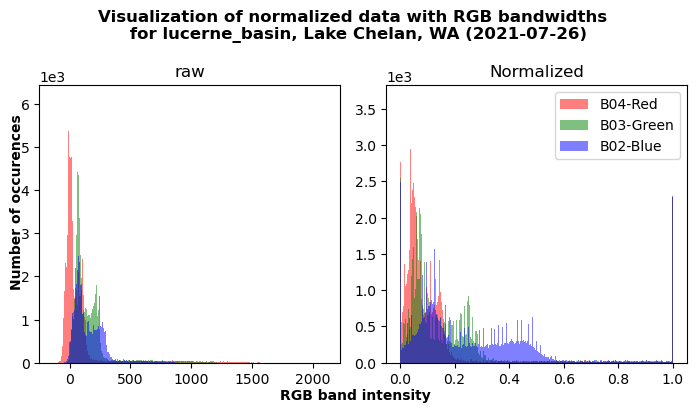

In [41]:
fig, axa = plt.subplots(1, 2, figsize=(7,4))
fig.suptitle(('Visualization of normalized data with RGB bandwidths \n for %s, Lake Chelan, WA (%s)' %(window_id, date)), 
             y=0.98,
             fontsize=12,
             fontweight='bold')

axa[0].hist(r_masked.compressed().ravel(), bins=512, alpha=0.5, color='red', log=False, label='B04-Red')
#ax.axvline(red_threshold, ls='--', c='k', label=red_threshold)

axa[0].hist(g_masked.compressed().ravel(), bins=512, alpha=0.5, color='green', log=False, label='B03-Green')
#ax.axvline(red_threshold, ls='--', c='k', label=red_threshold)

axa[0].hist(b_masked.compressed().ravel(), bins=512, alpha=0.5, color='blue', log=False, label='B02-Blue')
#ax.axvline(red_threshold, ls='--', c='k', label=red_threshold)

r_masked_normd = normie(r_masked, 2, 98)
axa[1].hist(r_masked_normd.compressed().ravel(), bins=512, alpha=0.5, color='red', log=False, label='B04-Red')
#ax.axvline(red_threshold, ls='--', c='k', label=red_threshold)

g_masked_normd = normie(g_masked, 2, 98)
axa[1].hist(g_masked_normd.compressed().ravel(), bins=512, alpha=0.5, color='green', log=False, label='B03-Green')
#ax.axvline(red_threshold, ls='--', c='k', label=red_threshold)

b_masked_normd = normie(b_masked, 2, 98)
axa[1].hist(b_masked_normd.compressed().ravel(), bins=512, alpha=0.5, color='blue', log=False, label='B02-Blue')
#ax.axvline(red_threshold, ls='--', c='k', label=red_threshold)

axa[0].ticklabel_format(axis='y', scilimits=(1,3))
axa[1].ticklabel_format(axis='y', scilimits=(1,3))


axa[0].set_title('raw')
axa[1].set_title('Normalized')

axa[1].legend()
#ax.xlim(-200, 500)
ax.set_ylabel('Number of occurences')
ax.set_xlabel('Band values')

fig.text(0.5, 0.006, 'RGB band intensity', fontweight='bold', ha='center')
fig.text(0.006, 0.5, 'Number of occurences', fontweight='bold', va='center', rotation='vertical')
#https://stackoverflow.com/questions/16150819/common-xlabel-ylabel-for-matplotlib-subplots

plt.tight_layout()

#save image output
strFile = ('/home/jovyan/project/chelanigans/output/%s/%s/visualize-normalization.png' %(notebook, window_id))
if os.path.isfile(strFile):
#os.remove(strFile)
    os.system("rm "+strFile)
plt.savefig(strFile);

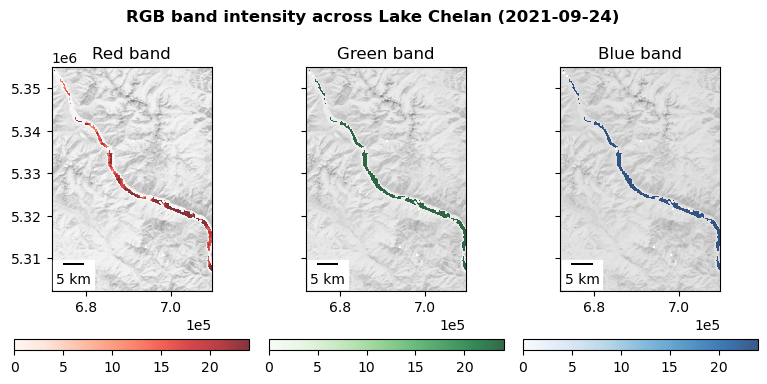

In [36]:
fig, axa = plt.subplots(1, 3, figsize=(8,4), sharex=True, sharey=True)
fig.suptitle(('RGB band intensity across Lake Chelan (%s)' %date), 
             y=0.98,
             fontsize=12,
             fontweight='bold')

axa[0].imshow(r, extent=window_extent, cmap='gray_r')
shw0 = axa[0].imshow(r_masked, cmap='Reds', extent=chelan_mask_extent, alpha=0.8, vmin=0, vmax=24)
bar = plt.colorbar(shw0, location='bottom')
axa[0].add_artist(ScaleBar(1.0, location='lower left'))
axa[0].set_title('Red band')
axa[0].ticklabel_format(scilimits=(1,3))
axa[0].set_xlim(window_extent[0], window_extent[1])
axa[0].set_ylim(window_extent[2], window_extent[3])

axa[1].imshow(g, extent=window_extent, cmap='gray_r')
shw1 = axa[1].imshow(g_masked, cmap='Greens', extent=chelan_mask_extent, alpha=0.8, vmin=0, vmax=24)
bar = plt.colorbar(shw1, location='bottom')
axa[1].add_artist(ScaleBar(1.0, location='lower left'))
axa[1].set_title('Green band')
axa[1].ticklabel_format(scilimits=(1,3))
axa[1].set_xlim(window_extent[0], window_extent[1])
axa[1].set_ylim(window_extent[2], window_extent[3])

axa[2].imshow(b, extent=window_extent, cmap='gray_r')
shw2 = axa[2].imshow(b_masked, cmap='Blues', extent=chelan_mask_extent, alpha=0.8, vmin=0, vmax=24)
bar = plt.colorbar(shw2, location='bottom')
axa[2].add_artist(ScaleBar(1.0, location='lower left'))
axa[2].set_title('Blue band')
axa[2].ticklabel_format(scilimits=(1,3))
axa[2].set_xlim(window_extent[0], window_extent[1])
axa[2].set_ylim(window_extent[2], window_extent[3])

plt.tight_layout()
#save image output
strFile = ('/home/jovyan/project/chelanigans/output/%s/%s/rgb_masked_%s.png' %(notebook, window_id, date))
if os.path.isfile(strFile):
#os.remove(strFile)
    os.system("rm "+strFile)
plt.savefig(strFile);

In [37]:
#set our index variables for 
#normalized difference turbidity index
#normalized difference suspended solids index

ndti = (r_masked - g_masked) / (r_masked + g_masked)
ndssi = (b_masked - nir_masked) / (b_masked + nir_masked)

#clip
ndti = np.ma.clip(ndti, -1, 1)
ndssi = np.ma.clip(ndssi, -1, 0)

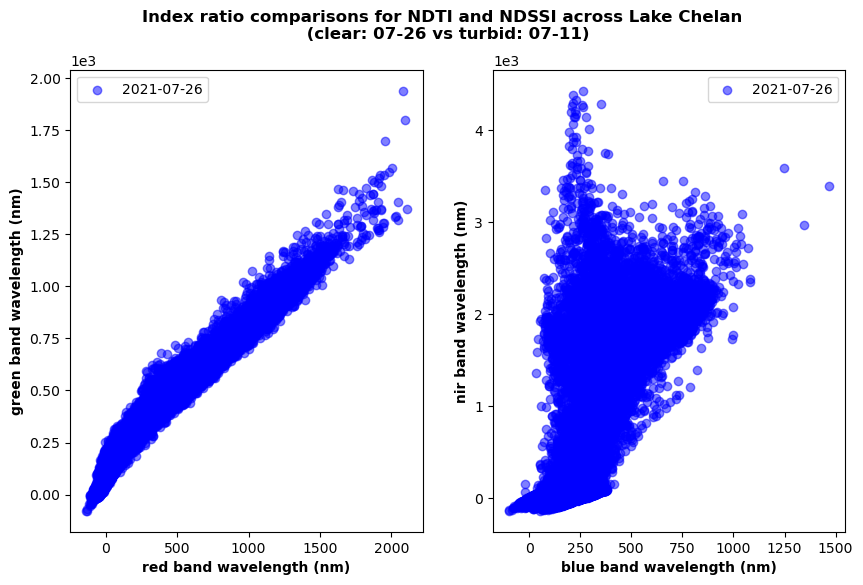

In [38]:
date_turb = date_list[-3]
img_turb = img_list[-3]
date_clear = date_list[-2]
img_clear = img_list[-2]

img_list_new = (img_clear, img_turb)
date_list_new = (date_clear, date_turb)
color_list = ('blue', 'red')

fig, axa = plt.subplots(1, 2, figsize=(10,6))
fig.suptitle(('Index ratio comparisons for NDTI and NDSSI across Lake Chelan \n (clear: %s vs turbid: %s)' %(date_list_new[0][5:], date_list_new[1][5:])), 
             y=.98,
             fontsize=12,
             fontweight='bold')

#img = i for i in img_list
#date = d for d in date_list

for i in enumerate(img_list_new[0:1]):
    img = str(i[1])
    index = (i[0])
    date = str(date_list_new[index])
    color = (color_list[index])

    #Specify filenames for different bands
    r_fn = os.path.join(imgdir, img+'.B04.tif') #Red
    g_fn = os.path.join(imgdir, img+'.B03.tif') #Green
    b_fn = os.path.join(imgdir, img+'.B02.tif') #Blue
    nir_fn = os.path.join(imgdir, img+'.B08.tif') #Near-Infrared (NIR08)

    # load window from red, green, blue tif files
    r = rio2ma(r_fn, b=1, window=window, scale=True)
    g = rio2ma(g_fn, b=1, window=window, scale=True)
    b = rio2ma(b_fn, b=1, window=window, scale=True)
    nir = rio2ma(nir_fn, b=1, window=window, scale=True)

    #chelan_json_url = '#https://geo.wa.gov/datasets/WSDOT::wsdot-major-lakes-1500k/explore?filters=eyJOQU1FIjpbIkxha2UgQ2hlbGFuIl19&location=48.085597%2C-120.767080%2C9.89'
    wa_lakes_gjson_url = '/home/jovyan/project/chelanigans/data/WSDOT_-_Major_Lakes_(1%3A500K).geojson'
    wa_lakes_gjson_gdf = gpd.read_file(wa_lakes_gjson_url) #just pointing to downloaded file for now
    #Reproject to match raster
    wa_lakes_gjson_gdf_proj = wa_lakes_gjson_gdf.to_crs(r_src.crs)
    #Isolate WA state
    chelan_gjson_iso = wa_lakes_gjson_gdf_proj.loc[wa_lakes_gjson_gdf_proj['NAME'] == 'Lake Chelan']
    #Extract geometry to use for clipping
    chelan_geom = chelan_gjson_iso.iloc[0].geometry

    #Pass this in to the `rio.mask.mask` call (see demo)
    rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
    #must pass chelan_geom polygon as list because rio.mask.mask expects multipolygon
    chelan_mask, chelan_mask_transform = rio.mask.mask(r_src, [chelan_geom,], **rio_mask_kwargs)

    #Get clipped extent in UTM coordinates
    chelan_mask_extent = rio.plot.plotting_extent(chelan_mask, chelan_mask_transform)
    chelan_mask_extent

    #mask rgb bands where
    r_masked = ma.masked_where(chelan_mask==True,r)
    g_masked = ma.masked_where(chelan_mask==True,g)
    b_masked = ma.masked_where(chelan_mask==True,b)
    nir_masked = ma.masked_where(chelan_mask==True,nir)

    axa[0].scatter(r_masked, g_masked, color=color, label=date, alpha=0.5)
    axa[0].set_xlabel('red band wavelength (nm)', fontweight='bold')
    axa[0].set_ylabel('green band wavelength (nm)', fontweight='bold')
    axa[0].legend()
    
    axa[1].scatter(b_masked, nir_masked, color=color, label=date, alpha=0.5);
    axa[1].set_xlabel('blue band wavelength (nm)', fontweight='bold')
    axa[1].set_ylabel('nir band wavelength (nm)', fontweight='bold')
    
    axa[0].ticklabel_format(axis='y', scilimits=(1,3))
    axa[1].ticklabel_format(axis='y', scilimits=(1,3))
    
    axa[1].legend()
#save image output
strFile = ('/home/jovyan/project/chelanigans/output/%s/%s/index-ratio-comparison.png' %(notebook, window_id))
if os.path.isfile(strFile):
#os.remove(strFile)
    os.system("rm "+strFile)
plt.savefig(strFile);

In [39]:
# turbid-day(7/11) data not showing
#attempting to fix loop

# date_turb = date_list[-3]
# img_turb = str(img_list[-3])
# date_clear = date_list[-2]
# img_clear = str(img_list[-2])

# img_list_new = {1: img_clear,
#                 2: img_turb}
# date_list_new = (date_clear, date_turb)
# color_list = ('blue', 'red')

# fig, axa = plt.subplots(1,2, figsize=(14, 8))
# fig.suptitle(('Index ratio comparisons for NDTI and NDSSI across Lake Chelan \n (clear:%s vs turbid:%s)' %(date_list_new[0], date_list_new[1])), 
#              y=0.95,
#              fontsize=14,
#              fontweight='bold')

# #img = i for i in img_list
# #date = d for d in date_list

# for i, img_l in enumerate(img_list_new):
#     index = i
#     img = img_l
#     date = date_list_new[i]
#     color = color_list[i]

#     #Specify filenames for different bands
#     r_fn = os.path.join(imgdir, img+'.B04.tif') #Red
#     g_fn = os.path.join(imgdir, img+'.B03.tif') #Green
#     b_fn = os.path.join(imgdir, img+'.B02.tif') #Blue
#     nir_fn = os.path.join(imgdir, img+'.B08.tif') #Near-Infrared (NIR08)

#     # load window from red, green, blue tif files
#     r = rio2ma(r_fn, b=1, window=window, scale=True)
#     g = rio2ma(g_fn, b=1, window=window, scale=True)
#     b = rio2ma(b_fn, b=1, window=window, scale=True)
#     nir = rio2ma(nir_fn, b=1, window=window, scale=True)

#     r_norm = normie(r, 2, 98)
#     g_norm = normie(g, 2, 98)
#     b_norm = normie(b, 2, 98)
#     nir_norm = normie(nir, 2, 98)

#     #chelan_json_url = '#https://geo.wa.gov/datasets/WSDOT::wsdot-major-lakes-1500k/explore?filters=eyJOQU1FIjpbIkxha2UgQ2hlbGFuIl19&location=48.085597%2C-120.767080%2C9.89'
#     wa_lakes_gjson_url = '/home/jovyan/project/chelanigans/data/WSDOT_-_Major_Lakes_(1%3A500K).geojson'
#     wa_lakes_gjson_gdf = gpd.read_file(wa_lakes_gjson_url) #just pointing to downloaded file for now
#     #Reproject to match raster
#     wa_lakes_gjson_gdf_proj = wa_lakes_gjson_gdf.to_crs(r_src.crs)
#     #Isolate WA state
#     chelan_gjson_iso = wa_lakes_gjson_gdf_proj.loc[wa_lakes_gjson_gdf_proj['NAME'] == 'Lake Chelan']
#     #Extract geometry to use for clipping
#     chelan_geom = chelan_gjson_iso.iloc[0].geometry

#     #Pass this in to the `rio.mask.mask` call (see demo)
#     rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
#     #must pass chelan_geom polygon as list because rio.mask.mask expects multipolygon
#     chelan_mask, chelan_mask_transform = rio.mask.mask(r_src, [chelan_geom,], **rio_mask_kwargs)

#     #Get clipped extent in UTM coordinates
#     chelan_mask_extent = rio.plot.plotting_extent(chelan_mask, chelan_mask_transform)
#     chelan_mask_extent

#     #mask rgb bands where
#     r_masked = ma.masked_where(chelan_mask==True,r)
#     g_masked = ma.masked_where(chelan_mask==True,g)
#     b_masked = ma.masked_where(chelan_mask==True,b)
#     nir_masked = ma.masked_where(chelan_mask==True,nir)

#     axa[0].scatter(r_masked, g_masked, color=color, label=date, alpha=0.5)
#     axa[0].set_xlabel('red band intensity')
#     axa[0].set_ylabel('green band intensity')
#     axa[0].legend()
    
#     axa[1].scatter(b_masked, nir_masked, color=color, label=date, alpha=0.5);
#     axa[1].set_xlabel('blue band intensity')
#     axa[1].set_ylabel('nir band intensity')
    
#     axa[1].legend();